In [1]:
!pip install gymnasium
!pip install pettingzoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
thinc 8.0.17 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow-transform 1.

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
import functools

import copy

import gymnasium
import numpy as np
from gymnasium.spaces import Discrete, Box, Sequence

from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers

from enum import Enum
import random

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
SIMULATION_LENGTH = 2000

NOOP = 6
SEND_TO_REMOTE = 5
MOVES = [0, 1, 2, 3, 4, SEND_TO_REMOTE, NOOP]

In [5]:
class MachineState(Enum):
    FREE = 0
    LOW = 1
    MED = 2
    HIGH = 3

# Reward and job definitions:
# 3 different job types: Low, Medium, High (L jobs are shorter, and H jobs take longer)
alpha_L, alpha_M, alpha_H = 0.7, 0.3, 0.1 # Probability of a job completing at any particular timestep
R_L, R_M, R_H = 20, 50, 80 # Rewards for each job type

machine_state_to_alpha_mapping = {
    MachineState.LOW: alpha_L,
    MachineState.MED: alpha_M,
    MachineState.HIGH: alpha_H
}

machine_state_to_reward_mapping = {
    MachineState.LOW: R_L,
    MachineState.MED: R_M,
    MachineState.HIGH: R_H
}
    


In [6]:

def make_env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
#     env = wrappers.AssertOutOfBoundsWrapper(env) # Do we need this anymore? It causes errors...
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    ##### Helper Functions #####
    def _generate_workload(self):
        # Equal chance of generating a Low, Medium or High job, or no job
        population = [MachineState.LOW, MachineState.MED, MachineState.HIGH, MachineState.FREE]
        weights = [0.25, 0.25, 0.25, 0]
        return random.choices(population=population, weights=weights)[0]
    
    ##### Environment Definitions #####
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """
    metadata = {"render_modes": ["human"], "name": "dmrs_v0"}

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - possible_agents
        - action_spaces
        - observation_spaces
        These attributes should not be changed after initialization.
        """
        self.possible_agents = ["datacentre_" + str(r) for r in range(2)]
        self.agent_name_mapping = dict(
            zip(self.possible_agents, list(range(len(self.possible_agents))))
        )
        # Encodes the entire system state. All machines start off as free. Status is either a job of type {job_status, datacentre, reward}, or FREE.
        self.machine_states = [[MachineState.FREE for _ in range(5)] for _ in range(2)]
        # Encodes the list of jobs arriving at all timesteps. Each job is a dict of {job_status, datacentre, reward}.
        self.job_queues = [
            [[] for _ in range(2)] for _ in range(SIMULATION_LENGTH)
        ]

        # Allocate to 5 machines, allocate to remote, NOOP
        self._action_spaces = { agent: Sequence(Discrete(5 + 1 + 1)) for agent in self.possible_agents } # Is this needed?

        # 5 machines, workload, workload_reward
        single_agent_observation_space = Box(low=-100, high=100, dtype=np.int32, shape=(5 + 1 + 1, )) # This is wrong now!
        self._observation_spaces = { agent: single_agent_observation_space for agent in self.possible_agents } # This is wrong now!
        self.render_mode = render_mode

    # this cache ensures that same space object is returned for the same agent
    # allows action space seeding to work as expected
    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # 5 machines, workload, workload_reward
        return Box(low=-100, high=100, dtype=np.int32, shape=(5 + 1 + 1, )) # This is wrong now!

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        # Allocate to 5 machines, allocate to remote, NOOP for each action per job
        job_queue = self._get_state[agent]['job_queue']
        return MultiDiscrete(np.array([7 for _ in range(len(job_queue))]))

    def render(self):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            state = self._get_state()
            string = f"Current state: datacentre_0: {state[self.agents[0]]} , datacentre_1: {state[self.agents[1]]}"
        else:
            string = "Game over"
        print(string)

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass
    
    def _get_remote_datacentre(self, agent, _action=None):
        """
        Returns the remote data centre associated with the action the given agent picked
        _action is currently unused as the environment only has 2 agents and hence is simple
        """
        assert agent in self.agents
        if agent == 'datacentre_0':
            return 'datacentre_1'
        else:
            return 'datacentre_0'
    
    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        return self.observations[agent]
    
    def _get_state(self):
        # machine_states: 0 if free, 1 if occupied
        # job_queue: list of jobs
        state = {
            agent: {
                "machine_states": [0 if machine_state == MachineState.FREE else 1 for machine_state in self.machine_states[self.agent_name_mapping[agent]]],
                "job_queue": self.job_queues[self.curr_timestep][self.agent_name_mapping[agent]]
            } for agent in self.agents
        }
        return state

    def reset(self, seed=None, return_info=False, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        # Encodes the entire system state. All machines start off as free. Status is either a job of type {job_status, datacentre, reward}, or FREE.
        self.machine_states = [[MachineState.FREE for _ in range(5)] for _ in range(2)]
        # Encodes the list of jobs arriving at all timesteps. Each job is a dict of {job_status, datacentre, reward}.
        self.job_queues = [
            [[] for _ in range(2)] for _ in range(SIMULATION_LENGTH)
        ]
        self.curr_timestep = 0
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.actions = {agent: [] for agent in self.agents}
        
        # Try and generate a job for each data centre
        for agent in self.agents:
            agent_num = self.agent_name_mapping[agent]
            new_job = self._generate_workload()
            if new_job != MachineState.FREE:
                self.job_queues[self.curr_timestep][agent_num].append({'job_status': new_job, 'datacentre': agent, 'reward': machine_state_to_reward_mapping[new_job]})
        
        self.observations = self._get_state()
                
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        agent = self.agent_selection
        
        # If the agent is first, we should reset all state for a clean observation this time step
        if self._agent_selector.is_first():
            self.actions = {agent: [] for agent in self.agents}

            # no rewards are allocated until both players give an action
            self._clear_rewards()

        # the agent which stepped last had its _cumulative_rewards accounted for
        # (because it was returned by last()), so the _cumulative_rewards for this
        # agent should start again at 0
        self._cumulative_rewards[agent] = 0

        # stores action of current agent
        self.actions[agent] = action # action is a list of actions for each job in the job queue

        # collect reward if it is the last agent to act
        if self._agent_selector.is_last():
            self.rewards['datacentre_0'] = 0
            self.rewards['datacentre_1'] = 0
            
            # Process actions for each agent:
            for agent in self.agents:
                for action, job in zip(self.actions[agent], self.observe(agent)['job_queue']):
                    if action == NOOP:
                        continue
                    if action == SEND_TO_REMOTE: # Send to remote
                        remote_datacentre = self._get_remote_datacentre(agent)
                        remote_datacentre_num = self.agent_name_mapping[remote_datacentre]
                        if self.curr_timestep + 1 < len(self.job_queues):
                            self.job_queues[self.curr_timestep + 1][remote_datacentre_num].append({'job_status': job['job_status'], 'datacentre': job['datacentre'], 'reward': job['reward'] - 10})
                    else: # Allocate to a local machine
                        agent_num = self.agent_name_mapping[agent]
                        machine_num = action
                        if self.machine_states[agent_num][machine_num] == MachineState.FREE:
                            self.machine_states[agent_num][machine_num] = job # Store whole job dict in machine state
                            self.rewards[job['datacentre']] += 5 # send reward for allocating the job to the original data centre
                        else:
                            self.rewards[job['datacentre']] -= 10 # penalize the original data centre #(Maybe this is something to think about later?)
                            
            # Workloads are completed based on their alpha values:
            for agent in self.agents:
                agent_num = self.agent_name_mapping[agent]
                for machine_num, workload in enumerate(self.machine_states[agent_num]): # [{'job_status': HIGH, 'datacentre': datacentre_0, 'reward': 40}, FREE, ...]
                    if workload != MachineState.FREE:
                        alpha = machine_state_to_alpha_mapping[workload['job_status']]
                        if random.random() < alpha:
                            self.machine_states[agent_num][machine_num] = MachineState.FREE
                            self.rewards[workload['datacentre']] += workload['reward']
                            
            
#             # TODO: Calculate rewards for all agents. Placeholder:
#             self.rewards[self.agents[0]] = 1
#             self.rewards[self.agents[1]] = 2
            
            # The truncations dictionary must be updated for all players.
            self.truncations = {
                agent: self.curr_timestep >= SIMULATION_LENGTH for agent in self.agents
            }
            
            self.curr_timestep += 1
            if self.curr_timestep < SIMULATION_LENGTH:
                # Observations at the start of the next timestep
                self.observations = self._get_state()
                
                # Try and generate a job for each data centre for the coming timestep
                for agent in self.agents:
                    agent_num = self.agent_name_mapping[agent]
                    new_job = self._generate_workload()
                    if new_job != MachineState.FREE:
                        self.job_queues[self.curr_timestep][agent_num].append({'job_status': new_job, 'datacentre': agent, 'reward': machine_state_to_reward_mapping[new_job]})
            
                

        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards() # Not even sure if I need this

        if self.render_mode == "human":
            self.render()

print("Loaded environment")

Loaded environment


In [7]:
def random_policy(agent, state_observation, job):
    return np.random.randint(5 + 1 + 1)

In [8]:
NUM_EPISODES = 50

env = make_env()

steps_done = 0

episode_returns = {
    "datacentre_0": [],
    "datacentre_1": []
}

for i_episode in range(NUM_EPISODES):
    if (i_episode+1) % 10 == 0:
        print("=====> episode ", i_episode+1, "/", NUM_EPISODES)
    env.reset()
    _observation, _reward, termination, truncation, _info = env.last()
    
    # Run an episode
    actions_taken = {
        "datacentre_0": None,
        "datacentre_1": None
    }
    state_observations = {
        "datacentre_0": env.observe("datacentre_0"),
        "datacentre_1": env.observe("datacentre_1")
    }
    rets = {
        "datacentre_0": 0,
        "datacentre_1": 0
    }
    for agent in env.agent_iter():
#         if env.env.curr_timestep % 500 == 0:
#             print(f"Timestep: {env.env.curr_timestep}")
            
        if termination or truncation:
            env.step(None)
            continue
        
        # Use the policy to get an action for each job in the job queue
        job_queue = state_observations[agent]['job_queue']
        actions = [NOOP for _ in range(len(job_queue))]
        for i, job in enumerate(job_queue):
            actions[i] = action = random_policy(agent, state_observations[agent]['machine_states'], job)
#         print(f"{agent} is taking actions {actions} for job queue {job_queue}")
        actions_taken[agent] = actions
        env.step(actions)
        
        _observation, _reward, termination, truncation, _info = env.last()


        if agent == "datacentre_1":
#             print(f"Finished one step, now at timestep {env.env.curr_timestep}") # Should have advanced to the next timestep (t)
            
            rets['datacentre_0'] += env.rewards['datacentre_0']
            rets['datacentre_1'] += env.rewards['datacentre_1']
            
            # TODO: Update agents' policies
#             print(f"Rewards (t-1): {env.rewards}")
#             print(f"Actions taken (t-1): {actions_taken}")
#             print(f"State Observations (t-1): {state_observations}") # previous state
            new_state_observations = {
                "datacentre_0": env.observe("datacentre_0"),
                "datacentre_1": env.observe("datacentre_1")
            }
#             print(f"State Observations (t): {new_state_observations}")
            # state_observations + actions_taken + rewards => update policy with these 
            
            # Advance state
            state_observations = new_state_observations
            # Reset actions taken
            actions_taken = {
                "datacentre_0": None,
                "datacentre_1": None
            }

#             print()
            
    episode_returns['datacentre_0'].append(rets['datacentre_0'])
    episode_returns['datacentre_1'].append(rets['datacentre_1'])

print("Done!")

=====> episode  10 / 50
=====> episode  20 / 50
=====> episode  30 / 50
=====> episode  40 / 50
=====> episode  50 / 50
Done!


Episode Returns:
{'datacentre_0': [46390, 45930, 46710, 44885, 48295, 48365, 45155, 46745, 49390, 46020, 47350, 46780, 43285, 46225, 46040, 45645, 48190, 47085, 46050, 47140, 45850, 46030, 44315, 46910, 45020, 45555, 49430, 48250, 44155, 48095, 46185, 47755, 47965, 45940, 43630, 45585, 45915, 47875, 45295, 43825, 46215, 47145, 46160, 48820, 46955, 45845, 47300, 46040, 45495, 45630], 'datacentre_1': [50830, 44720, 45800, 47045, 43585, 46205, 43595, 44945, 45400, 48800, 46225, 45550, 46440, 47865, 44755, 45765, 48040, 46005, 48490, 43925, 44235, 46360, 45465, 47630, 47860, 44555, 48380, 49115, 46215, 45910, 46530, 44955, 47205, 46690, 43835, 45725, 46385, 47850, 44540, 47035, 47375, 50480, 46730, 46030, 48710, 47335, 46210, 45715, 48740, 48585]}

Total System Reward:
[97220 90650 92510 91930 91880 94570 88750 91690 94790 94820 93575 92330
 89725 94090 90795 91410 96230 93090 94540 91065 90085 92390 89780 94540
 92880 90110 97810 97365 90370 94005 92715 92710 95170 92630 87465 91310
 9230

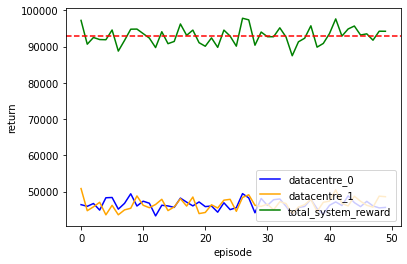

In [9]:
print("Episode Returns:")
print(episode_returns)
print()

total_system_reward = np.array(episode_returns['datacentre_0']) + np.array(episode_returns['datacentre_1'])
total_system_reward_mean = np.mean(total_system_reward)
print("Total System Reward:")
print(total_system_reward)
print("Mean:", total_system_reward_mean)
print()


plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_0'], label="datacentre_0", color='blue')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_1'], label="datacentre_1", color='orange')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), total_system_reward, label="total_system_reward", color='green')
plt.ylabel("return")
plt.xlabel("episode")

plt.axhline(y=total_system_reward_mean, color='r', linestyle='--')

plt.legend(loc='lower right')
# plt.savefig(f'/kaggle/working/{filename}.png')
plt.show()

In [10]:
def greedy_policy(agent, state_observation, job):
    for machine_num, machine_state in enumerate(state_observation):
        if machine_state == 0:
            return machine_num
    return NOOP

In [11]:
NUM_EPISODES = 50

env = make_env()

steps_done = 0

episode_returns = {
    "datacentre_0": [],
    "datacentre_1": []
}

for i_episode in range(NUM_EPISODES):
    if (i_episode+1) % 10 == 0:
        print("=====> episode ", i_episode+1, "/", NUM_EPISODES)
    env.reset()
    _observation, _reward, termination, truncation, _info = env.last()
    
    # Run an episode
    actions_taken = {
        "datacentre_0": None,
        "datacentre_1": None
    }
    state_observations = {
        "datacentre_0": env.observe("datacentre_0"),
        "datacentre_1": env.observe("datacentre_1")
    }
    rets = {
        "datacentre_0": 0,
        "datacentre_1": 0
    }
    for agent in env.agent_iter():
#         if env.env.curr_timestep % 500 == 0:
#             print(f"Timestep: {env.env.curr_timestep}")
            
        if termination or truncation:
            env.step(None)
            continue
        
        # Use the policy to get an action for each job in the job queue
        job_queue = state_observations[agent]['job_queue']
        actions = [NOOP for _ in range(len(job_queue))]
        for i, job in enumerate(job_queue):
            actions[i] = action = greedy_policy(agent, state_observations[agent]['machine_states'], job)
#         print(f"{agent} is taking actions {actions} for job queue {job_queue}")
        actions_taken[agent] = actions
        env.step(actions)
        
        _observation, _reward, termination, truncation, _info = env.last()


        if agent == "datacentre_1":
#             print(f"Finished one step, now at timestep {env.env.curr_timestep}") # Should have advanced to the next timestep (t)
            
            rets['datacentre_0'] += env.rewards['datacentre_0']
            rets['datacentre_1'] += env.rewards['datacentre_1']
            
            # TODO: Update agents' policies
#             print(f"Rewards (t-1): {env.rewards}")
#             print(f"Actions taken (t-1): {actions_taken}")
#             print(f"State Observations (t-1): {state_observations}") # previous state
            new_state_observations = {
                "datacentre_0": env.observe("datacentre_0"),
                "datacentre_1": env.observe("datacentre_1")
            }
#             print(f"State Observations (t): {new_state_observations}")
            # state_observations + actions_taken + rewards => update policy with these 
            
            # Advance state
            state_observations = new_state_observations
            # Reset actions taken
            actions_taken = {
                "datacentre_0": None,
                "datacentre_1": None
            }

#             print()
            
    episode_returns['datacentre_0'].append(rets['datacentre_0'])
    episode_returns['datacentre_1'].append(rets['datacentre_1'])

print("Done!")

=====> episode  10 / 50
=====> episode  20 / 50
=====> episode  30 / 50
=====> episode  40 / 50
=====> episode  50 / 50
Done!


Episode Returns:
{'datacentre_0': [94225, 90095, 92680, 89090, 89855, 92250, 92065, 88775, 93735, 91220, 93290, 93650, 88245, 93880, 91200, 90980, 92160, 92465, 90535, 89110, 92770, 93875, 93240, 91965, 92250, 91265, 88805, 91620, 91255, 91390, 90785, 89335, 89315, 92780, 92795, 89820, 91925, 93635, 93915, 90260, 93795, 94280, 89555, 89775, 91075, 92540, 89925, 92350, 92575, 92370], 'datacentre_1': [90815, 90965, 93980, 91810, 88905, 92810, 92220, 93310, 90945, 93260, 92965, 90690, 91745, 94095, 94695, 93110, 91695, 87200, 89870, 94180, 93980, 92905, 91300, 95250, 93520, 90180, 93050, 92845, 90985, 89750, 91630, 91790, 91275, 95165, 93495, 93970, 91150, 94235, 94290, 90415, 92505, 92300, 93245, 93445, 92580, 93570, 90445, 92295, 92135, 91420]}

Total System Reward:
[185040 181060 186660 180900 178760 185060 184285 182085 184680 184480
 186255 184340 179990 187975 185895 184090 183855 179665 180405 183290
 186750 186780 184540 187215 185770 181445 181855 184465 182240 181140
 182415 181

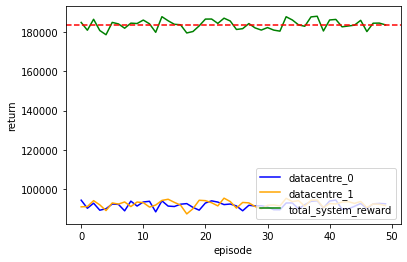

In [12]:
print("Episode Returns:")
print(episode_returns)
print()

total_system_reward = np.array(episode_returns['datacentre_0']) + np.array(episode_returns['datacentre_1'])
total_system_reward_mean = np.mean(total_system_reward)
print("Total System Reward:")
print(total_system_reward)
print("Mean:", total_system_reward_mean)
print()


plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_0'], label="datacentre_0", color='blue')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_1'], label="datacentre_1", color='orange')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), total_system_reward, label="total_system_reward", color='green')
plt.ylabel("return")
plt.xlabel("episode")

plt.axhline(y=total_system_reward_mean, color='r', linestyle='--')

plt.legend(loc='lower right')
# plt.savefig(f'/kaggle/working/{filename}.png')
plt.show()